# Direct compression examples

In this notebook we will show how to perform full shape fits to data power spectrum, using Taylor expansion to speed up likelihood evaluation.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
fo = cosmo.get_fourier()
pk = fo.pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = fo.sigma8_z(z, of='theta_cb') / fo.sigma8_z(z, of='delta_cb')
shotnoise = 1 / 5e-4
volume = 1e10

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1000):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

## Direct likelihood

In [2]:
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.parameter import ParameterCollection
from desilike import setup_logging


template = DirectPowerSpectrumTemplate(z=z, fiducial='DESI')
for param in ['omega_b', 'n_s']: template.params[param].update(fixed=True)
theory = KaiserTracerPowerSpectrumMultipoles(template=template)
theory.params['b1'].update(value=2.)
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=mocks,
                                                     klim={0: [0.02, 0.2], 2: [0.02, 0.2]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])



# NOTE: if we wanted to fit xi instead:
# theory = KaiserTracerCorrelationFunctionMultipoles(template=template)
# observable = ObservedTracerCorrelationFunction(data=data, covariance=mocks,
#                                                slim={0: [40., 160], 2: [40., 160]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
#                                                theory=theory)
# The rest would be the same

setup_logging()
likelihood()  # just to initialize

[000000.14] [0/1] 02-05 14:14  ObservablesGaussianLikelihood INFO     Covariance matrix with 36 points built from 999 observations.
[000000.14] [0/1] 02-05 14:14  ObservablesGaussianLikelihood INFO     ...resulting in Hartlap factor of 0.9629.
[000000.89] [0/1] 02-05 14:14  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000000.90] [0/1] 02-05 14:14  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.90] [0/1] 02-05 14:14  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.90] [0/1] 02-05 14:14  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000000.91] [0/1] 02-05 14:14  absl                      WARNING  No GPU/TPU found, falling bac

DeviceArray(-17.311165, dtype=float64)

[000003.17] [0/1] 02-05 14:14  Emulator                  INFO     Varied parameters: ['h', 'Omega_m', 'logA', 'b1', 'sn0'].
[000003.17] [0/1] 02-05 14:14  Emulator                  INFO     Found varying ['power'] and fixed ['k', 'ells'] outputs.
[000003.17] [0/1] 02-05 14:14  Differentiation           INFO     Varied parameters: ['h', 'Omega_m', 'logA', 'b1', 'sn0'].
[000005.11] [0/1] 02-05 14:14  Differentiation           INFO     Using finite-differentiation for parameter h.
[000005.48] [0/1] 02-05 14:14  Differentiation           INFO     Using finite-differentiation for parameter Omega_m.
[000005.88] [0/1] 02-05 14:14  Differentiation           INFO     Using finite-differentiation for parameter logA.
[000006.94] [0/1] 02-05 14:14  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000007.67] [0/1] 02-05 14:14  Differentiation           INFO     Using auto-differentiation for parameter sn0.
[000007.67] [0/1] 02-05 14:14  Differentiation           INFO

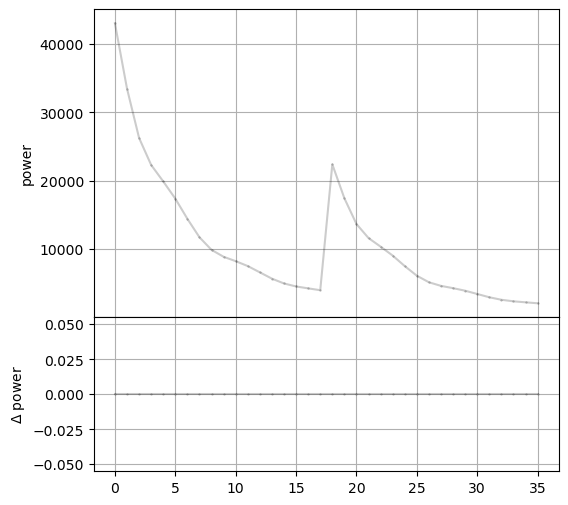

In [3]:
from desilike.emulators import Emulator, EmulatedCalculator, TaylorEmulatorEngine

emulator = Emulator(theory, engine=TaylorEmulatorEngine(order={'*': 2, 'sn0': 1}))  # order 2 except for sn0 (order 1 is enough)
emulator.set_samples()
emulator.fit()
emulator.plot(name='power')

import os
base_dir = '_tests'
kaiser_emulator_fn = os.path.join(base_dir, 'kaiser_emulator.npy')
emulator.save(kaiser_emulator_fn)

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [4]:
from desilike.samplers import ZeusSampler

# Let's just update the observable's theory, no need to redefine the observable & likelihood
# (Internally the code will reinitialize all calculators that depend on observable)
observable.init.update(theory=emulator.to_calculator())

sampler = ZeusSampler(likelihood, save_fn='_tests/chain_fs_direct_*.npy', seed=42)
sampler.run(check={'max_eigen_gr': 0.1})

[000032.75] [0/1] 02-05 14:15  ObservablesGaussianLikelihood INFO     Covariance matrix with 36 points built from 999 observations.
[000032.75] [0/1] 02-05 14:15  ObservablesGaussianLikelihood INFO     ...resulting in Hartlap factor of 0.9629.
[000032.76] [0/1] 02-05 14:15  ZeusSampler               INFO     Varied parameters: ['h', 'Omega_m', 'logA', 'b1', 'sn0'].
[000033.14] [0/1] 02-05 14:15  root                      INFO     Initialising ensemble of 12 walkers...
[000282.23] [0/1] 02-05 14:19  Chain                     INFO     Saving _tests/chain_fs_direct_0.npy.
[000282.23] [0/1] 02-05 14:19  ZeusSampler               INFO     Diagnostics:
[000282.24] [0/1] 02-05 14:19  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.187; not < 0.1.
[000282.25] [0/1] 02-05 14:19  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0422.
[000282.26] [0/1] 02-05 14:19  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.13.
[000282

[Chain(shape=(900, 12), params=ParameterCollection(['h', 'Omega_m', 'logA', 'b1', 'sn0', 'logposterior', 'omega_b', 'n_s', 'tau_reio', 'm_ncdm', 'N_ur', 'w0_fld', 'wa_fld', 'Omega_k', 'sigmapar', 'sigmaper', 'loglikelihood', 'logprior']))]

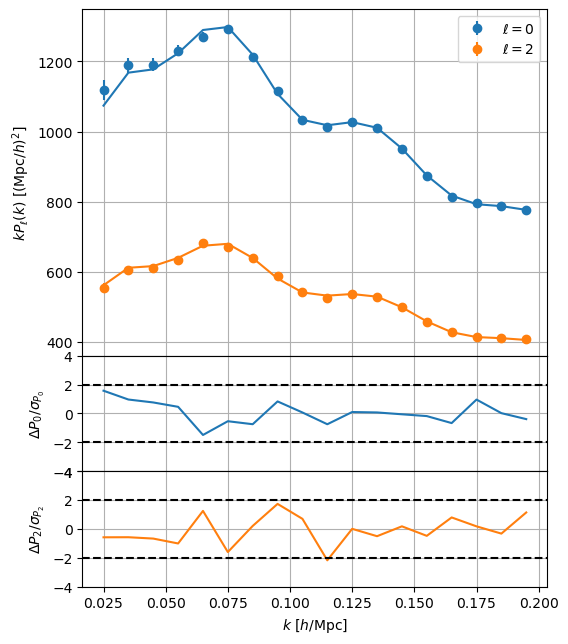

In [5]:
likelihood(**sampler.chains[0].choice(params=likelihood.varied_params))
observable.plot()
plt.show()

In [6]:
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+---------+--------+--------+--------+--------+-----------------+-----------------+
|         | argmax |  mean  | median |  std   | quantile:1sigma | interval:1sigma |
+---------+--------+--------+--------+--------+-----------------+-----------------+
|    h    | 0.6762 | 0.6775 | 0.6778 | 0.0048 | -0.0047/+0.0047 | -0.0047/+0.0047 |
| Omega_m | 0.3124 | 0.3113 | 0.3110 | 0.0044 | -0.0043/+0.0044 | -0.0047/+0.0039 |
|  logA   | 3.042  | 3.039  | 3.039  | 0.014  |  -0.014/+0.015  |  -0.013/+0.016  |
|   b1    | 1.985  | 1.987  | 1.988  | 0.012  |  -0.012/+0.012  |  -0.011/+0.013  |
|   sn0   |   22   |   21   |   22   |   31   |     -31/+31     |     -28/+35     |
+---------+--------+--------+--------+--------+-----------------+-----------------+


Removed no burn in


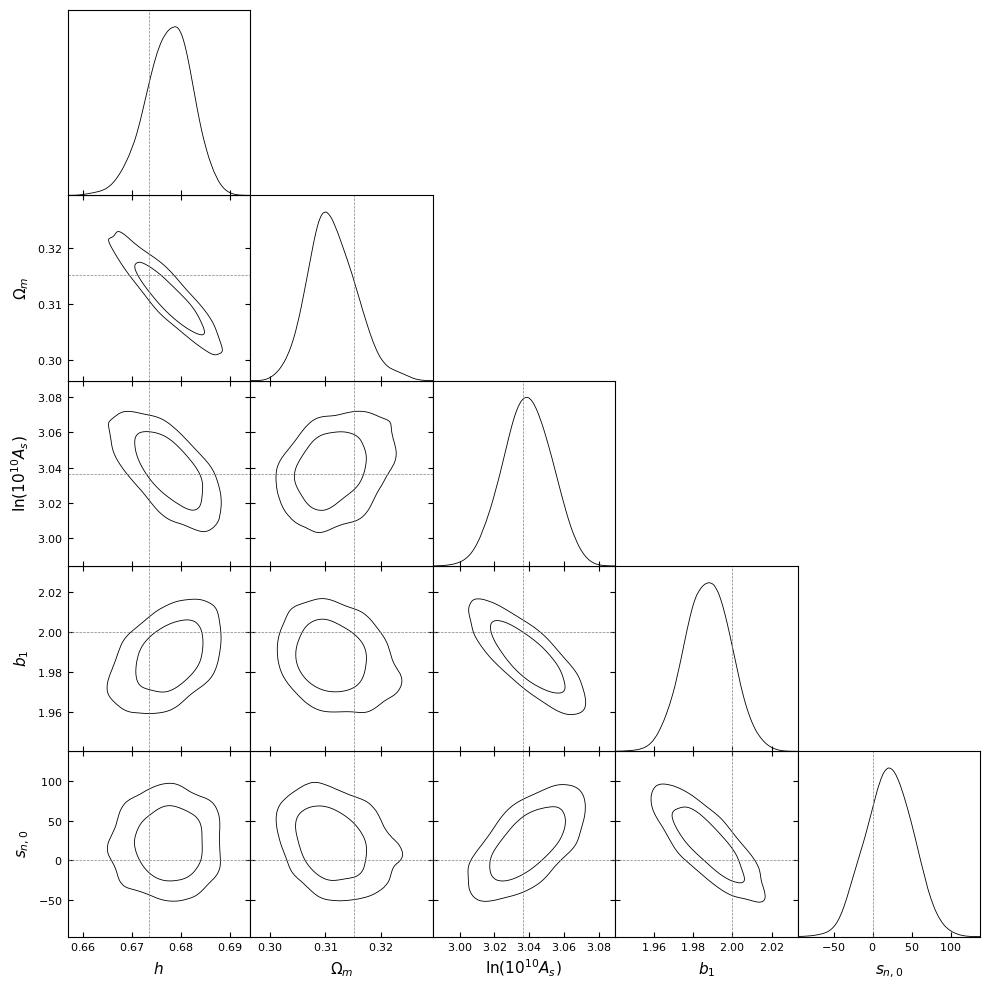

In [9]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'Omega_m': cosmo.Omega0_m, 'h': cosmo.h, 'logA': np.log(10**10 * cosmo.A_s), 'n_s': cosmo.n_s, 'b1': b, 'sn0': 0.})